# Mini-projet géophysique : interpolation de données manquantes

*Contexte* : dans le cadre d'acquisition de données sismiques, des capteurs (récepteurs) sont positionnés le long d'une ligne à la surface de la terre. Chacun enregistre au cours du temps le déplacement des particules (signal oscillant) qui varie lors du passage d'une onde acoustique ou élastique. Cet enregistrement s'appelle une **trace**. C'est une colonne dans les représentation graphiques plus bas.

En pratique, il arrive que certains capteurs soient défaillants ou encore qu'ils ne soient pas présents dans certaines zones (pour des problèmes d'accessibilité par exemple). L'objectif principal du mini-projet est de reconstituer les traces manquantes.

*Hypothèses* : nous ferons l'hypothèse que les **signaux sont essentiellement linéraires** dans les enregistrements (i.e. on peut localement déduire la trace suivante à partir de la trace précédente, avec un décalage en temps qui est proportionnel à la distance entre les traces). L'approximation linéaire est explicitée plus bas.

*Notions abordées* : 
* Lien entre la représentation avant et après transformée de Fourier 2d
* Effets de bords

Pour cela, nous considérons l'approche suivante :
* Transformée de Fourier 2d
* Identification des événements principaux
* Définition d'un masque
* Reconstitution des traces manquantes par transformee de Fourier inverse

L'approche est appliquée sur 3 jeux de données : 
* Donnees simples (un seul événement) : `gpanel1.npy`
* Donnees complexes (4 événements) : `gpanel2.npy`
* Sur vos propres données.

*Attentes* :
* Regard critique sur les résulats obtenus
* Inventivité (pour la troisième application)

*Consignes* :
* **Très important**: pour toutes les figures, bien indiquer les axes avec les bonnes unités et des labels lisibles

In [3]:
# Modules
import numpy as np
import matplotlib.pyplot as plt

**Lecture des données**

In [4]:
# Labelsize (display)
labelsize   = 14
    
# Load the simple input data
# Input data (with missing traces)
gpanel1 = np.load('gpanel1.npy')
# Dense data (with all traces, only for comparison)
panel_dense1 = np.load('panel_dense1.npy')
nt, nx = gpanel1.shape
print("Taille des données :",nt,nx)

# Missing traces (index number)
mtr = [2,5,6,11,12,20,21,22,23]

# Vertical axis -- time
dt   = 3.125e-3  # increment (s)
at   = np.linspace(0,dt*(nt-1),nt)
# Horizontal axis -- space
dx   = 10. # increment (m)
ax   = np.linspace(0,dx*(nx-1),nx)

Taille des données : 400 30


**Affichage des données**

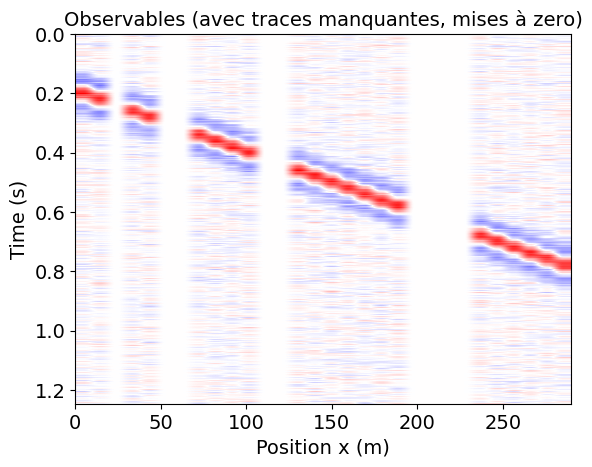

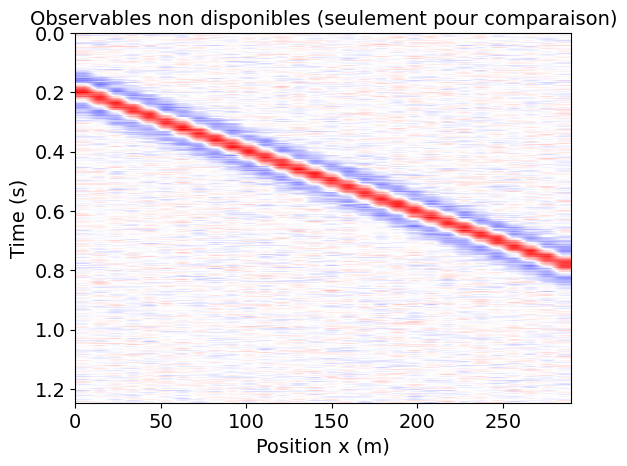

In [5]:
# Display of the input data
vmax    = np.max(np.abs(gpanel1))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel1,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense1,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Partie 1. Données simples (7 points)

## Approche théorique

On peut supposer que $$u(t,x) = S\big(t-t_0-p_0(x-x_0)\big)$$

C'est l'approximation linéaire mentionnée plus haut,
avec $S(t)$ une ondelette source, $t_0$ le temps à la position $x=x_0$, et la pente $p_0$ en s/m associée à l'événement. Ici : $t_0=0.2$ s (pour $x_0 = 0$ m) et $p_0=0.002$ s/m.

Tracer la droite définie par $t_0$ et $p_0$ sur les observables (`gpanel1`) pour vérifier qu'elle se superpose bien à l'événement principal.


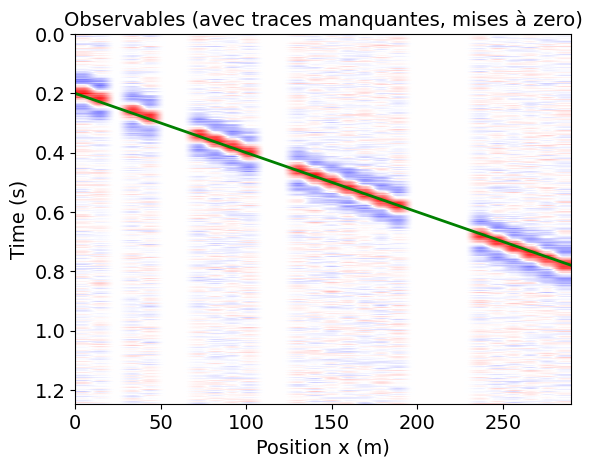

In [14]:
vmax = np.max(np.abs(gpanel1))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel1,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

#Tracer la droite 
t0 = 0.2
x0 = 0 
p0 = 0.002
x_range = np.array([ax[0], ax[-1]])  # valeurs x pour tracer la droite
t_line = t0 + p0 * (x_range - x0)  

plt.plot(x_range, t_line, color='green', linewidth=2)


plt.show()


Calculer l'expression de la transformée de Fourier 2d $\hat{u}(\omega,k)$ de $u(t,x)$ à partir de la transformée de Fourier 1d $\hat{S}(\omega)$ de $S(t)$. En déduire une expression simple de $|\hat{u}|$ en lien avec $|\hat{S}(\omega)|$. Expliquer toujours à partir des équations pourquoi on s'attend à avoir un événement linéaire dans le domaine de Fourier. Pourquoi l'événement passe-t-il par l'origine $(0,0)$ dans le domaine de Fourier? Donner une expression quantitative entre la pente dans le domaine de Fourier $(\omega,k)$ et la pente dans le domaine $(t,x)$.

Pour simplifier l'expression, on peut utiliser

$$\int dx e^{-i k x} = \delta(k)$$

avec $\delta$ la distribution de Dirac.

## Implémentation
Représenter la transformée de Fourier 2d et bien préciser les axes. Faire le lien entre l'événement dans l'espace $(t,x)$ et celui dans l'espace de Fourier. Comme pour le domaine $(t,x)$, tracer la droite correspondante dans le domaine $(\omega,k)$. Expliquer ce qu'il se passe aux bords dans le domaine de Fourier. N'hésitez pas à zoomer autour de la position centrale $(0,0)$ dans le domaine de Fourier pour une meilleure représentation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


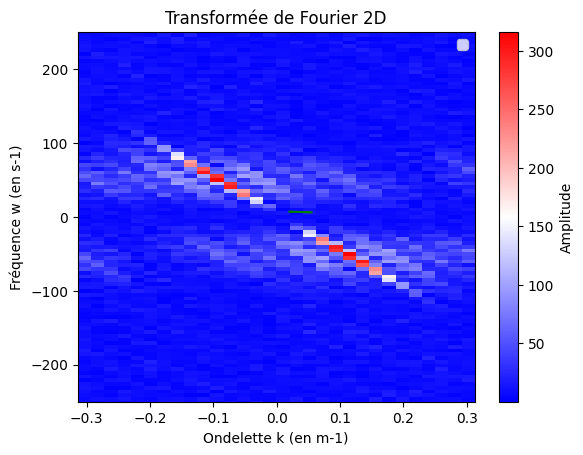

In [42]:
tf = np.fft.fftshift(np.fft.fft2(gpanel1))
# fftshift est utilisé pour recentrer les fréquences à zéro

#renormalisation de la fréquence et du vecteur d'onde
n = gpanel1.shape[0]
dt = np.abs(at[1] - at[0]) 
dx = np.abs(ax[1] - ax[0])
dw = 2 * np.pi / (n * dt) 
dk = 2 * np.pi / (n * dx)
w = np.fft.fftshift(np.fft.fftfreq(n, dt)) * 2 * np.pi 
k = np.fft.fftshift(np.fft.fftfreq(n, dx)) * 2 * np.pi

# tracer 
plt.imshow(np.abs(tf), extent=[k[0], k[-1], w[-1], w[0]], aspect='auto')

plt.title('Transformée de Fourier 2D')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')

plt.ylim((-250,250)) #afin d'améliorer l'affichage 
plt.colorbar(label='Amplitude')

plt.legend()

droite = []
for i in range (gpanel1.shape[0]): 
    for j in range (gpanel1.shape[1]) :
        if abs(tf[i][j]) >= 220 : 
            droite.append((i,j))

x_droite = [(point[1]/gpanel1.shape[0]) for point in droite]
y_droite = [(point[0]/gpanel1.shape[1])  for point in droite]
plt.plot(x_droite, y_droite, color='green', label='Droite')


plt.show()

## Définition d'un masque dans le domaine de Fourier 2d
On note $\omega$ la fréquence angulaire et $k$ le nombre d'onde. Dans le domaine de Fourier 2d, on souhaite définir un masque avec des 1 qui couvrent les événements principaux. A partir de $(\omega,k)=(0,0)$, faire des sommations selon différentes pentes (dans le domaine de Fourier, après avoir pris le module des valeurs complexes) et tracer la valeur de ces sommes en fonction de la pente. On s'attend à ce que une valeur ressorte. Calculer une fonction qui sélectionne automatiquement cette valeur et construire un masque dans le domaine de Fourier 2d qui vaut 1 autour de la valeur principale et 0 en dehors.

## Application du masque et analyse des résultats
Appliquer le masque (sur les données après transformée de Fourier 2d, sans prendre le module des valeurs), puis appliquer la transformée de Fourier inverse. Commenter les résultats. Si nécessaire, revenir à la question précédente pour changer la forme du masque et avoir une meilleure interpolation des données. Expliquer ces changements. Discuter de l'importance du masque.

# Partie 2. Données complexes (7 points)

Recommencer la même procédure (interpolation des données) sur les données plus complexes (`gpanel2.npy`). Analyser les similitudes et différences, et en particulier les difficultés rencontrées.

Les pentes sont : 
$p_0 = 0.006$, $p_1 = 0.002$, $p_2 = -0.004$ et $p_3 = -0.0005$ en s/m 
et les temps associes (pour $x_0=0$ m) : $t_0 = 0.1$, $t_1 = 0.3$, $t_2 = 1.1$ et $t_3 = 1.8$ en s.


In [7]:
# Load the input data
# Input data (with missing traces)
gpanel2 = np.load('gpanel2.npy')
# Dense data (with all traces, only for comparison)
panel_dense2 = np.load('panel_dense2.npy')
nt, nx = gpanel2.shape
print("Taille des données :",nt,nx)


Taille des données : 400 30


**Affichage des données**

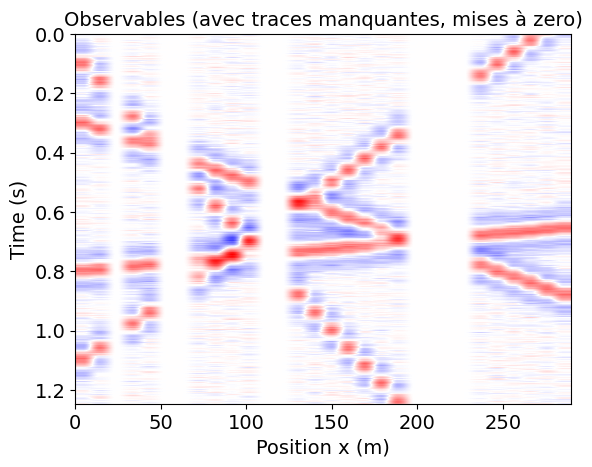

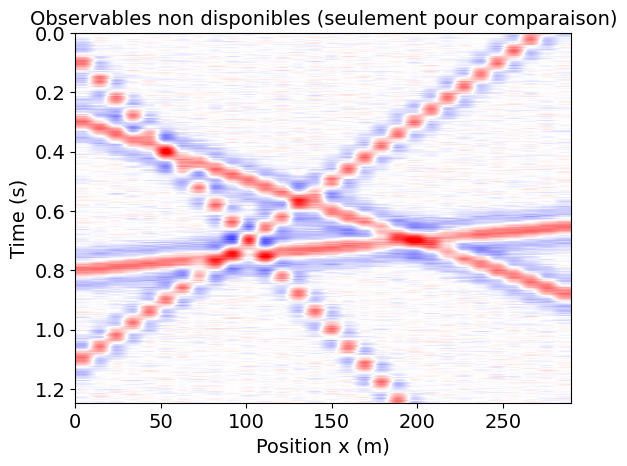

In [8]:
# Display of the input data
vmax    = np.max(np.abs(gpanel2))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel2,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense2,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Partie 3. Analyse des limites de l'approche (6 points)
Proposer une nouvelle application sur votre propre jeu de donnees. Vous pouvez par exemple :
* ajouter du bruit sur gpanel1 ou gpanel2
* enlever encore plus de données en entrée (plus de traces blanches) 
* tester sur vos propres données / sur des images récupérées sur internet

Illustrer et discuter une limite (ou plusieurs) que rencontre l'interpolation dans le domaine de Fourier.

**Cette dernière partie est très ouverte et je fais appel à votre créativité.**